In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso
from sklearn.metrics import roc_auc_score, auc, roc_curve
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report
from test_function import *
import random
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from test_function import *
from sklearn.ensemble import GradientBoostingClassifier
from scipy import stats

import statsmodels.stats.proportion as proportion

In [2]:
x_column = ['SIFT_pred','LRT_pred', 'MA_pred', 'PROVEN_pred', 'SLR_score', 'SIFT_score','LRT_omega', 
                'MA_score', 'PROVEN_score', 'Grantham', 'HMMEntropy','HMMRelEntropy', 'PredRSAB', 'PredRSAI', 
                'PredRSAE','PredBFactorF', 'PredBFactorM', 'PredBFactorS', 'PredStabilityH','PredStabilityM', 
                'PredStabilityL', 'PredSSE', 'PredSSH','PredSSC', 'dscore', 'phyloP_pri', 'phyloP_mam','phyloP_ver','RNA_seq','UNEECON']
y_column = 'clinvar_result'



In [3]:
# processing data
# balanced omit
omit = pd.read_csv("unannotated_omit_std.tsv", sep = "\t")
dominant = pd.read_csv('dominant_std.tsv', sep = "\t")
recessive = pd.read_csv('recessive_std.tsv', sep = "\t")

In [4]:
omit = preprocess(omit, 'clinvar_result',Balanced = True)

Unbalanced,
with num of 0 is 46363, num of 1 is 31317.

start balancing...
with num of 0 is 31317, num of 1 is 31317.



In [5]:
# creating training set, validation set, testing set
def split(df, Xname, Yname, testsize = 0.1):
    y = df.loc[:,[Yname]].values
    y = y.flatten()
    X = df.loc[:,Xname]
    Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size = testsize, random_state = 42)
    
    
    
    Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size = testsize, random_state = 42)    
    Xtrain, Xvalid, ytrain, yvalid =  train_test_split(Xtrain,ytrain, test_size = 0.11, random_state = 42)
    
    return(Xtrain, Xvalid, Xtest, ytrain, yvalid, ytest)


X_train, X_valid, X_test, y_train, y_valid, y_test = split(omit, x_column, y_column)
X_train_domi, X_valid_domi, X_test_domi, y_train_domi, y_valid_domi, y_test_domi = split(dominant, x_column, y_column)
X_train_recess, X_valid_recess, X_test_recess, y_train_recess, y_valid_recess, y_test_recess = split(recessive, x_column, y_column)
   

In [6]:
#add new column to original df
def merge(df1, df2, column):
    df3 = df1.copy()
    df3[column] = df2.tolist()
    return(df3)

In [7]:
train3 = merge(X_train, y_train, 'clinvar_result')
train3_domi = merge(X_train_domi, y_train_domi, 'clinvar_result')
train3_recess = merge(X_train_recess, y_train_recess, 'clinvar_result')

valid = merge(X_valid, y_valid, 'clinvar_result')
valid_domi = merge(X_valid_domi, y_valid_domi, 'clinvar_result')
valid_recess = merge(X_valid_recess, y_valid_recess, 'clinvar_result')

In [8]:
## skip this part when rerun 

train3.to_csv('/storage/home/jkl5991/work/project/not_conflict/cv/0730/original/train.tsv', sep = '\t',index = False)
train3_domi.to_csv('/storage/home/jkl5991/work/project/not_conflict/cv/0730/original/train_domi.tsv', sep = '\t',index = False)
train3_recess.to_csv('/storage/home/jkl5991/work/project/not_conflict/cv/0730/original/train_recess.tsv', sep = '\t',index = False)


valid.to_csv('/storage/home/jkl5991/work/project/not_conflict/cv/0730/original/valid.tsv', sep = '\t',index = False)
valid_domi.to_csv('/storage/home/jkl5991/work/project/not_conflict/cv/0730/original/valid_domi.tsv', sep = '\t',index = False)
valid_recess.to_csv('/storage/home/jkl5991/work/project/not_conflict/cv/0730/original/valid_recess.tsv', sep = '\t',index = False)

In [8]:
def drawROC(ytest, ytest_hat, lw=3, linestyle = '--', label = '', lastone = False, MoreThanOnelocation = 'lower right', fontsize = 12, title = '', legendloc = False):
    fpr, tpr, thresholds = roc_curve(ytest, ytest_hat)
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr, tpr, lw = lw, linestyle = linestyle, label = label + ', (AUC = %0.3f)'%roc_auc)
    if lastone == True:
        if legendloc != False:
            ax.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=lengend,borderaxespad=0, frameon=False)
        else:
            plt.legend(loc = 'lower right', fontsize = 12)
        plt.title(title)
        
        fig = plt.figure()
        return(fig)

    
def get_ROC(ax,ytest, ytest_hat, label, lastone = False, x = 'FPR', y = 'TPR', title = None, legendloc = 'lower right', lw = 2, linestyle = '-'):
    fpr, tpr, thresholds = roc_curve(ytest, ytest_hat)
    auroc = auc(fpr,tpr)
    ax.plot(fpr, tpr, lw = lw, linestyle = linestyle, label = label +', (AUC = %0.3f)'%auroc)
    if(lastone == True):
        ax.set_xlabel(x)
        ax.set_ylabel(y)
        ax.set_title(title)
        ax.legend(loc='lower right',fontsize = 12)

/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

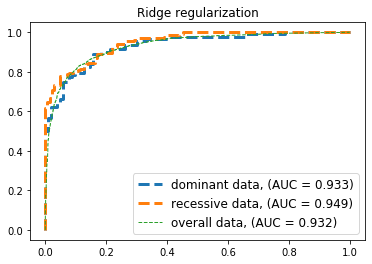

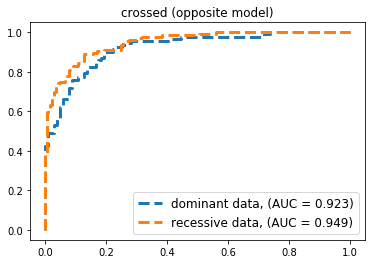

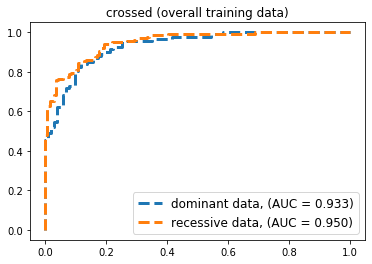

<Figure size 432x288 with 0 Axes>

In [9]:
#logistic regression
def logistic(Xtrain, ytrain, Xtest, ytest, fitmodel = False):    
    if(fitmodel != False):
        model = fitmodel
        
    else:
        model = LogisticRegression(random_state = 42 , penalty = 'l2').fit(Xtrain, ytrain)
        
    test_hat = model.predict_proba(Xtest)[:,1]
    return(ytest,test_hat, model)


domi_l2 = logistic(X_train_domi, y_train_domi, X_test_domi, y_test_domi)
recess_l2 = logistic(X_train_recess, y_train_recess, X_test_recess, y_test_recess)
omit_l2 = logistic(X_train, y_train, X_test, y_test)
plt.rcParams['figure.figsize'] = [6,4]


drawROC(domi_l2[0], domi_l2[1],label = 'dominant data')
drawROC(recess_l2[0],recess_l2[1], label = "recessive data")
drawROC(omit_l2[0],omit_l2[1], lw =1,label = "overall data",lastone = True, title = "Ridge regularization")

# ridge cross
domi_l2_cross = logistic(0, 0, X_test_domi, y_test_domi, fitmodel = recess_l2[2])
recess_l2_cross = logistic(0,0, X_test_recess, y_test_recess, fitmodel = domi_l2[2])


drawROC(domi_l2_cross[0], domi_l2_cross[1],label = 'dominant data')
drawROC(recess_l2_cross[0],recess_l2_cross[1], label = "recessive data", lastone = True, title = "crossed (opposite model)")



# overall crossed
domi_l2_overall = logistic(0,0,X_test_domi, y_test_domi, fitmodel = omit_l2[2])
recess_l2_overall = logistic(0,0,X_test_recess, y_test_recess, fitmodel = omit_l2[2])



drawROC(domi_l2_overall[0], domi_l2_overall[1],label = 'dominant data')
drawROC(recess_l2_overall[0],recess_l2_overall[1], label = "recessive data", lastone = True, title = "crossed (overall training data)")



In [10]:
coef_domi = domi_l2[2].coef_.flatten()
coef_recess = recess_l2[2].coef_.flatten()
coef_overall = omit_l2[2].coef_.flatten()

cor_reg = pd.DataFrame({'domi_ridge':coef_domi, 'recess_ridge': coef_recess, 'overall': coef_overall}, index = x_column)
print(cor_reg)


                domi_ridge  recess_ridge   overall
SIFT_pred        -0.103581      0.219523  0.653349
LRT_pred          0.534392      0.444339  0.476416
MA_pred           0.212353      0.067671 -0.017159
PROVEN_pred       0.899139      0.240607  0.397403
SLR_score        -0.248228      0.004266 -0.056289
SIFT_score       -0.073085     -0.146165  0.104149
LRT_omega        -0.111733     -0.281798  0.001018
MA_score          0.317031      0.209090  0.446644
PROVEN_score      0.235627     -0.696776 -0.334095
Grantham          0.329480     -0.065062  0.004424
HMMEntropy        0.531986      0.126446 -0.285760
HMMRelEntropy    -0.301048      0.053138  0.404657
PredRSAB         -0.006284      0.020531 -0.011912
PredRSAI          0.210760      0.066158  0.008465
PredRSAE         -0.067893      0.015529  0.005388
PredBFactorF      0.284134      0.203819 -0.026375
PredBFactorM      0.088672     -0.011707 -0.129079
PredBFactorS      0.262424      0.097404 -0.050239
PredStabilityH   -0.258981     

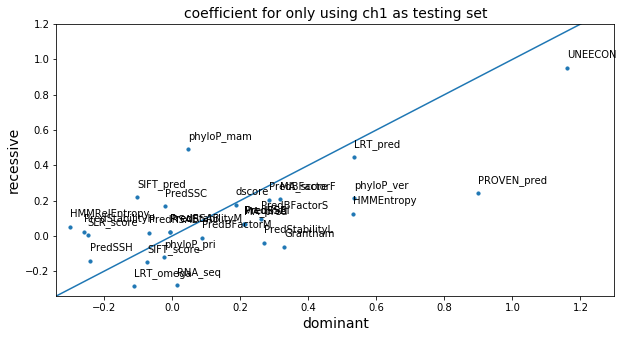

In [14]:
plt.rcParams['figure.figsize'] = [10,5]
a = np.arange(-1,4)
plt.plot(a,a)
#plt.rcParams['figure.figsize'] = [20,10]
plt.scatter(cor_reg['domi_ridge'], cor_reg['recess_ridge'], s = 10)
i = 0
for x,y in zip(cor_reg['domi_ridge'], cor_reg['recess_ridge']):
    label = x_column[i]    
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords = "offset points", # how to position the text
                 xytext=(0,10,), # distance from text to points (x,y)
                 size = 10)
    i += 1
plt.xlim(-0.34,1.3)
plt.ylim(-0.34,1.2)
plt.title('coefficient for only using ch1 as testing set', size =14)
plt.xlabel('dominant', size = 14)
plt.ylabel('recessive', size = 14) 
plt.show()
#plt.savefig('figure/4_line_log_coefficient.pdf')  

In [9]:
# SVM
def svm_model(Xtrain, ytrain, Xtest, ytest,C, gamma, bestkernel, model = False):
    if(model != False):
        clf = model
        
    else: 
        print(C, gamma, bestkernel)
        clf = SVC(kernel = bestkernel, C = C, gamma = gamma)
        clf.fit(Xtrain, ytrain)

    test_hat = clf.decision_function(Xtest)
    return(ytest, test_hat, clf)


In [10]:
svm_domi = svm_model( X_train_domi, y_train_domi, X_test_domi, y_test_domi, 10, 0.01, 'rbf')
svm_recess = svm_model(X_train_recess, y_train_recess, X_test_recess, y_test_recess, 10,0.01, 'rbf')
svm_omit = svm_model(X_train, y_train, X_test, y_test,1,0.1, 'rbf')

10 0.01 rbf
10 0.01 rbf
1 0.1 rbf


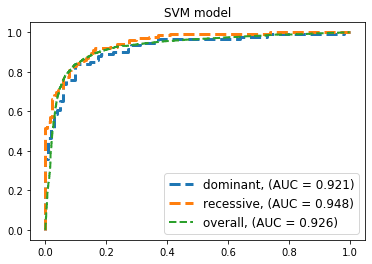

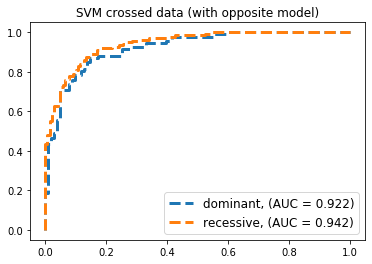

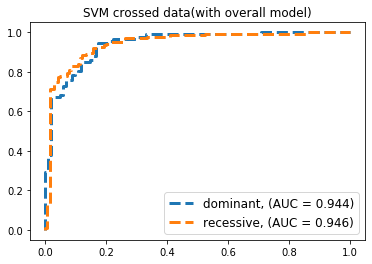

In [18]:
plt.rcParams['figure.figsize'] = [6,4]
drawROC(svm_domi[0],svm_domi[1], label = 'dominant')
drawROC(svm_recess[0],svm_recess[1], label = 'recessive')
drawROC(svm_omit[0],svm_omit[1], lw = 2,label = 'overall', lastone = True, title = 'SVM model')

#cross model(dominant & recessive)
domi_cross = svm_model(0,0,X_test_domi, y_test_domi,0,0,0, model = svm_recess[2])
recess_cross = svm_model(0,0,X_test_recess, y_test_recess,0,0,0, model = svm_domi[2])

drawROC(domi_cross[0], domi_cross[1], label = 'dominant')
drawROC(recess_cross[0], recess_cross[1], label = 'recessive', lastone = True, title = 'SVM crossed data (with opposite model)')

#cross model(with overall data)
domi_overall = svm_model(0,0,X_test_domi, y_test_domi, 0,0,0, model = svm_omit[2])
recess_overall = svm_model(0,0,X_test_recess, y_test_recess, 0,0,0, model = svm_omit[2])

drawROC(domi_overall[0], domi_overall[1], label = 'dominant')
drawROC(recess_overall[0], recess_overall[1], label = 'recessive', lastone = True, title = 'SVM crossed data(with overall model)')

10 0.01 rbf
1 0.1 rbf


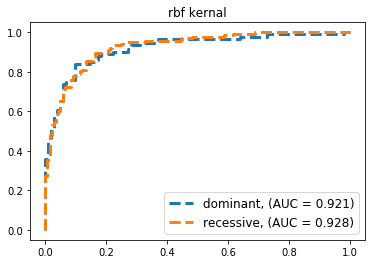

1 0.01 linear
10 0.01 linear


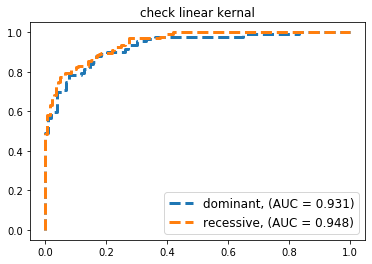

In [24]:
# ## dont need to run again
# # recheck 0804
# svm_domi = svm_model( X_train2_domi, y_train2_domi, X_test_domi, y_test_domi,10, 0.01, 'rbf')
# svm_recess = svm_model(X_train2_recess, y_train2_recess, X_test_recess, y_test_recess, 1, 0.1, 'rbf')


# drawROC(svm_domi[0],svm_domi[1], label = 'dominant')
# drawROC(svm_recess[0],svm_recess[1], label = 'recessive', lastone = True, title = 'rbf kernal')



# #compared with linear kernal
# svm_domi = svm_model( X_train2_domi, y_train2_domi, X_test_domi, y_test_domi,1,0.01, 'linear')
# svm_recess = svm_model(X_train2_recess, y_train2_recess, X_test_recess, y_test_recess, 10,0.01, 'linear')

# plt.rcParams['figure.figsize'] = [6,4]
# drawROC(svm_domi[0],svm_domi[1], label = 'dominant')
# drawROC(svm_recess[0],svm_recess[1], label = 'recessive', lastone = True, title = "check linear kernal")

10 0.01 rbf
1 0.1 rbf


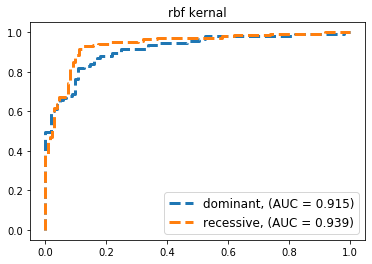

1 0.01 linear
10 0.01 linear


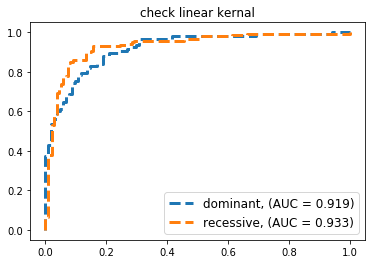

In [27]:
# # recheck 0804 
# #use validation dataset as testing dataset ( test if the validation dataset is biased)

# svm_domi = svm_model( X_train2_domi, y_train2_domi, X_valid_domi, y_valid_domi,10,0.01, 'rbf')
# svm_recess = svm_model(X_train2_recess, y_train2_recess, X_valid_recess, y_valid_recess, 1,0.1, 'rbf')


# drawROC(svm_domi[0],svm_domi[1], label = 'dominant')
# drawROC(svm_recess[0],svm_recess[1], label = 'recessive', lastone = True, title = 'rbf kernal')



# #compared with linear kernal
# svm_domi = svm_model( X_train2_domi, y_train2_domi, X_valid_domi, y_valid_domi,1,0.01, 'linear')
# svm_recess = svm_model(X_train2_recess, y_train2_recess, X_valid_recess, y_valid_recess, 10,0.01, 'linear')

# plt.rcParams['figure.figsize'] = [6,4]
# drawROC(svm_domi[0],svm_domi[1], label = 'dominant')
# drawROC(svm_recess[0],svm_recess[1], label = 'recessive', lastone = True, title = "check linear kernal")





1 0.01 linear
10 0.01 linear
100 0.01 linear


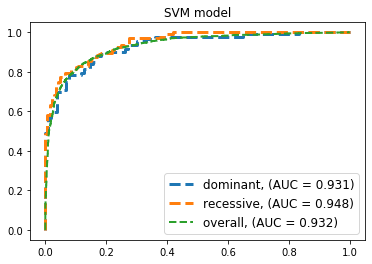

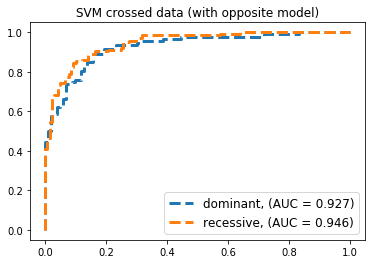

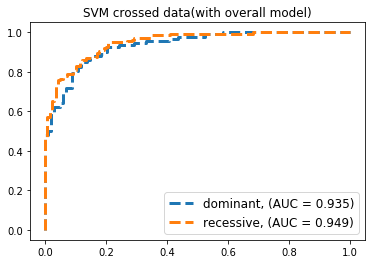

In [155]:
#linear model
#### rerun!!(change valid with testing data)
svm_domi = svm_model( X_train2_domi, y_train2_domi, X_test_domi, y_test_domi,1,0.01, 'linear')
svm_recess = svm_model(X_train2_recess, y_train2_recess, X_test_recess, y_test_recess, 10,0.01, 'linear')
svm_omit = svm_model(X_train, y_train, X_test, y_test, 100,0.01, 'linear')
 
plt.rcParams['figure.figsize'] = [6,4]
drawROC(svm_domi[0],svm_domi[1], label = 'dominant')
drawROC(svm_recess[0],svm_recess[1], label = 'recessive')
drawROC(svm_omit[0],svm_omit[1], lw = 2,label = 'overall', lastone = True, title = 'SVM model')

#cross model(dominant & recessive)
domi_cross = svm_model(0,0,X_test_domi, y_test_domi,0,0,0, model = svm_recess[2])
recess_cross = svm_model(0,0,X_test_recess, y_test_recess,0,0,0, model = svm_domi[2])

drawROC(domi_cross[0], domi_cross[1], label = 'dominant')
drawROC(recess_cross[0], recess_cross[1], label = 'recessive', lastone = True, title = 'SVM crossed data (with opposite model)')

#cross model(with overall data)
domi_overall = svm_model(0,0,X_test_domi, y_test_domi, 0,0,0, model = svm_omit[2])
recess_overall = svm_model(0,0,X_test_recess, y_test_recess, 0,0,0, model = svm_omit[2])

drawROC(domi_overall[0], domi_overall[1], label = 'dominant')
drawROC(recess_overall[0], recess_overall[1], label = 'recessive', lastone = True, title = 'SVM crossed data(with overall model)')

In [8]:
# gradient boosting
tuned_parameters = {"learning_rate" : [0.05,0.1,0.15], 
                   "n_estimators": [100,150,200],
                    "max_depth": [3,5,8]}

In [10]:
#dominant
tuning(X_valid_domi, y_valid_domi, 'gradient boosting', tuned_parameters)

# Tuning hyper-parameters for recall



/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
With score : 0.806

Grid scores on development set:

0.764 (+/-0.064) for {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
0.769 (+/-0.075) for {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 150}
0.775 (+/-0.089) for {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
0.758 (+/-0.054) for {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
0.742 (+/-0.033) for {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 150}
0.748 (+/-0.049) for {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}
0.747 (+/-0.098) for {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 100}
0.753 (+/-0.087) for {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 150}
0.753 (+/-0.087) for {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 200}
0.785 (+/-0.075) for {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
0.780 (+/-0.088) for {

In [11]:
#recessive
tuning(X_valid_recess, y_valid_recess, 'gradient boosting', tuned_parameters)

# Tuning hyper-parameters for recall



/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'learning_rate': 0.15, 'max_depth': 5, 'n_estimators': 200}
With score : 0.873

Grid scores on development set:

0.866 (+/-0.079) for {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
0.869 (+/-0.089) for {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 150}
0.866 (+/-0.079) for {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
0.847 (+/-0.028) for {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
0.844 (+/-0.009) for {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 150}
0.847 (+/-0.018) for {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}
0.829 (+/-0.036) for {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 100}
0.829 (+/-0.051) for {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 150}
0.836 (+/-0.042) for {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 200}
0.859 (+/-0.059) for {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
0.859 (+/-0.059) for 

In [12]:
#overall
tuning(X_valid, y_valid, 'gradient boosting', tuned_parameters)

# Tuning hyper-parameters for recall



/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameters set found on development set:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150}
With score : 0.866

Grid scores on development set:

0.863 (+/-0.008) for {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
0.864 (+/-0.006) for {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 150}
0.864 (+/-0.006) for {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
0.863 (+/-0.012) for {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
0.866 (+/-0.010) for {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 150}
0.865 (+/-0.007) for {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}
0.862 (+/-0.009) for {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 100}
0.863 (+/-0.009) for {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 150}
0.862 (+/-0.010) for {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 200}
0.864 (+/-0.008) for {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
0.866 (+/-0.006) for {

In [11]:
def fitting_gb(Xtrain, ytrain, Xtest, ytest, learning, depth, estimator, fitmodel = False):
    if(fitmodel == False):
        model = GradientBoostingClassifier(learning_rate = learning, max_depth = depth, n_estimators = estimator, subsample = 1)
        model.fit(Xtrain, ytrain)
    else:
        model = fitmodel
    
    model_pred = model.decision_function(Xtest)
    
    return(ytest, model_pred, model)

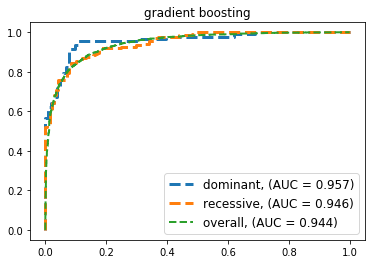

In [14]:
domi_gb = fitting_gb(X_train_domi, y_train_domi, X_test_domi, y_test_domi, 0.1, 3, 150)
recess_gb = fitting_gb( X_train_recess, y_train_recess, X_test_recess, y_test_recess, 0.1, 5, 200)
omit_gb = fitting_gb(X_train, y_train, X_test, y_test, 0.1, 3, 150)

plt.rcParams['figure.figsize'] = [6,4]
drawROC(domi_gb[0], domi_gb[1], label = 'dominant')
drawROC(recess_gb[0], recess_gb[1], label = 'recessive')
drawROC(omit_gb[0], omit_gb[1], label = 'overall', lw = 2, lastone = True, title = 'gradient boosting')

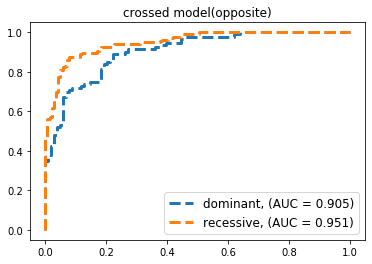

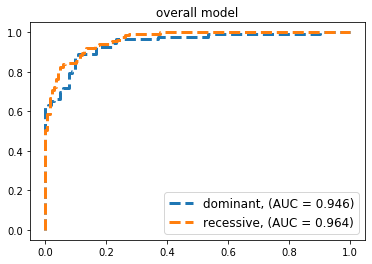

In [15]:
# cross model
domi_cross_gb = fitting_gb(0,0,X_test_domi, y_test_domi,0,0,0, fitmodel = recess_gb[2])
recess_cross_gb = fitting_gb(0,0, X_test_recess, y_test_recess ,0,0,0, fitmodel = domi_gb[2])

drawROC(domi_cross_gb[0], domi_cross_gb[1], label = 'dominant')
drawROC(recess_cross_gb[0], recess_cross_gb[1], label = 'recessive', lastone = True, title = 'crossed model(opposite)')


# using overall model
domi_overall_gb = fitting_gb(0,0,X_test_domi, y_test_domi,0,0,0, fitmodel = omit_gb[2])
recess_overall_gb = fitting_gb(0,0,X_test_recess, y_test_recess,0,0,0, fitmodel = omit_gb[2])

drawROC(domi_overall_gb[0], domi_overall_gb[1], label = 'dominant')
drawROC(recess_overall_gb[0], recess_overall_gb[1], label = 'recessive', lastone = True, title = 'overall model')



In [20]:
comparison = pd.DataFrame({'result':y_test, 'logistic':omit_l2[1] ,'svm': svm_omit[1],'boosting': omit_gb[1]})

comparison.to_csv('~/work/project/not_conflict/r_noconflict/0730/original/overall_comparison.tsv', sep = '\t',index = False)

In [24]:
comparison

0       0
1       1
2       0
3       1
4       0
       ..
6259    0
6260    0
6261    1
6262    0
6263    1
Name: result, Length: 6264, dtype: int64

In [19]:
domi_comparison = pd.DataFrame({'result':y_test_domi, 'logistic':domi_l2[1],'svm': svm_domi[1], 'boosting': domi_gb[1], 'opposite_model':domi_cross_gb[1], 'omit_model':domi_overall_gb[1]})

recess_comparison = pd.DataFrame({'result':y_test_recess, 'logistic':recess_l2[1],'svm': svm_recess[1], 'boosting': recess_gb[1], 'opposite_model':recess_cross_gb[1], 'omit_model':recess_overall_gb[1]})

domi_comparison.to_csv('~/work/project/not_conflict/r_noconflict/0730/original/dominant_comparison.tsv', sep = '\t',index = False)
recess_comparison.to_csv('~/work/project/not_conflict/r_noconflict/0730/original/recessive_comparison.tsv', sep = '\t',index = False)

In [18]:
domi_comparison

,result,logistic,svm,boosting,opposite_model,omit_model
0,0,0.056805,-1.240975,-0.896808,-3.348142,-1.376754
1,0,0.015027,-2.305266,-4.082787,-5.421150,-3.002903
2,1,0.945310,1.546526,2.656577,2.979834,3.223028
3,1,0.889233,0.871057,0.734799,4.903363,2.602514
4,1,0.934011,1.702698,2.875863,2.730264,2.369629
...,...,...,...,...,...,...
190,1,0.983708,2.425677,4.605025,0.600090,3.971966
191,1,0.985195,1.777817,2.856986,3.485283,3.327735
192,0,0.210832,-0.949794,-2.297616,-2.548894,-2.321189
193,0,0.145422,-0.920632,0.204052,-2.560930,-1.206831


In [10]:
def drawROC2(ytest, ytest_hat, lw=3, linestyle = '--', label = '', lastone = False, MoreThanOnelocation = 'lower right', fontsize = 12, title = '', legendloc = ''):
    fpr, tpr, thresholds = roc_curve(ytest, ytest_hat)
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr, tpr, lw = lw, linestyle = linestyle, label = label + ', (AUC = %0.3f)'%roc_auc)
    if lastone == True:
        if legendloc != '':
            plt.legend(loc='upper center', bbox_to_anchor= (0.0, 1.7), ncol=legendloc, borderaxespad=0, frameon=False)
        else:
            plt.legend(loc = 'lower right', fontsize = 12)
        plt.title(title)
        plt.show()

In [11]:
# check supervised and unsupervised performance

                
# x_ind_column = ['MA_score', 'PROVEN_score','Grantham','HMMEntropy','HMMRelEntropy', 'PredRSAI', 'PredSSE','PredRSAB','PredStabilityH',
#                 'PredBFactorF', 'dscore', 'phyloP_pri', 'phyloP_mam','phyloP_ver','RNA_seq','UNEECON',
#                 'SLR_score', 'LRT_omega',,  'PredRSAB','PredBFactorF', 'PredBFactorM', 'PredBFactorS', 
#                 'PredStabilityM', 'PredStabilityL','PredSSH','PredSSC' ]

# x_ind_col_neg = ['SLR_score','SIFT_score', 'LRT_omega','PROVEN_score'  
#                          , 'PredBFactorM', 'PredBFactorS', 'PredRSAE',
#                          'PredStabilityM', 'PredStabilityL','PredSSH','PredSSC']



x_ind_column = ['SLR_score', 'SIFT_score','LRT_omega', 
                'MA_score', 'PROVEN_score', 'Grantham', 'HMMEntropy','HMMRelEntropy', 'PredRSAB', 'PredRSAI', 
                'PredRSAE','PredBFactorF', 'PredBFactorM', 'PredBFactorS', 'PredStabilityH','PredStabilityM', 
                'PredStabilityL', 'PredSSE', 'PredSSH','PredSSC', 'dscore', 'phyloP_pri', 'phyloP_mam','phyloP_ver','RNA_seq','UNEECON']


x_ind_col_neg = ['SLR_score', 'SIFT_score','LRT_omega', 'PROVEN_score','PredRSAE', 'PredBFactorM', 'PredBFactorS',
                'PredStabilityL','PredSSH','PredSSC',]

def ind(x_column, data, neg_col):
    pred = {}
    for column in data[x_column]:
        #print(column)
        y_ind = data.loc[:,column]
        #print(y_ind.shape)
        if(column in x_ind_col_neg):
            #print(y_ind)
            #print('negative')
            y_ind = -y_ind
            #print(y_ind)
            #print('')
        pred[column] = y_ind
    return(pred)



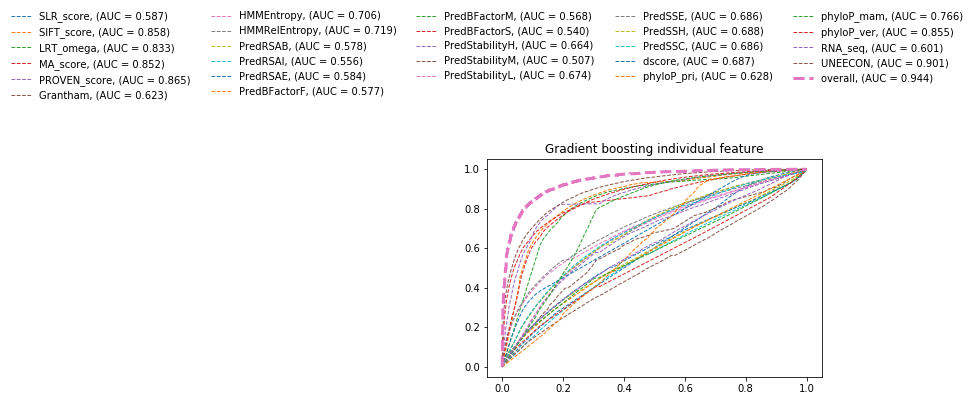

In [13]:
ind_col = ind(x_ind_column, omit, x_ind_col_neg)
#print(ind_col)
ind_col2 = pd.DataFrame(ind_col) 


for i in ind_col2:
    drawROC2(omit.loc[:,'clinvar_result'], ind_col2.loc[:,i], lw = 1, label = i)
drawROC2(omit_gb[0], omit_gb[1], label = 'overall', lastone = True,legendloc = 5, title = 'Gradient boosting individual feature')

[[94  9]
 [ 9 83]]


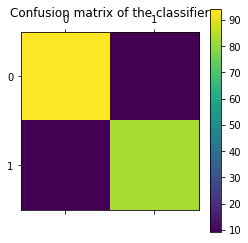

[[95  8]
 [11 81]]


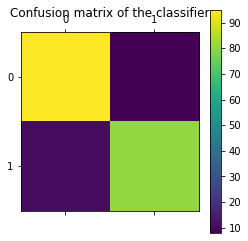

[[89 14]
 [ 5 87]]


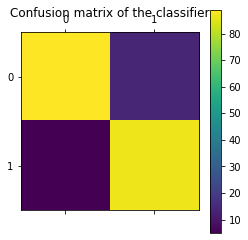

[[103   0]
 [ 92   0]]


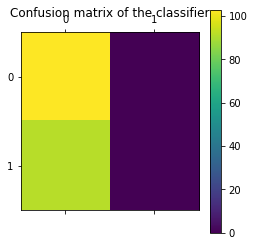

In [73]:
# decide cutoff 
from sklearn.metrics import confusion_matrix
import pylab as pl

def confusionmatrix(correct, predict, cutoff):
    predict_binary = np.copy(predict)
    predict_binary[predict_binary > cutoff ] = 1
    predict_binary[predict_binary <=  cutoff ] = 0
    cm = confusion_matrix(correct, predict_binary)
    print(cm)
    pl.matshow(cm)
    pl.title('Confusion matrix of the classifier')
    pl.colorbar()
    pl.show()
    
    
    
confusionmatrix(domi_gb[0], domi_gb[1], 0 )
confusionmatrix(domi_gb[0], domi_gb[1],0.5)
confusionmatrix(domi_gb[0], domi_gb[1],-0.5)
confusionmatrix(domi_gb[0], domi_gb[1],1)

(array([3229.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3035.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

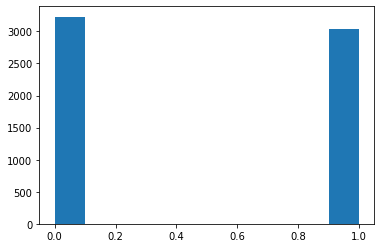

In [151]:
plt.hist(omit_gb[1])

In [17]:
column_list = ['chrom','pos','ID','ref','alt','qual','filter','info']
clinvar = pd.read_csv('/storage/home/jkl5991/work/project/original_data/clinvar_20200113.vcf', sep='\t', header=None, comment='#', names = column_list)
clinvar.head()
clinvar.columns = column_list
clinvar = clinvar[clinvar['ref'].str.len() == clinvar['alt'].str.len()]
clinvar = clinvar.assign( location = 'chr' + clinvar['chrom'].astype(str) + '-' + (clinvar['pos']-1).astype(str) +\
                     '-' + clinvar['pos'].astype(str) +'-'+ clinvar['ref'].astype(str) +'-'+ clinvar['alt'].astype(str))

/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [16]:
## get correct/incorrect index number

def prediction_location(predict, correct):
    false_nagative= false_positive= true_positive= true_negative = 0
    # transferring it into binary data
    
    predict_binary = predict
    predict_binary[predict_binary > 0 ] = 1
    predict_binary[predict_binary < 0 ] = 0
    wrong_prediction = np.where(predict_binary != correct)
    
    #positive = 1 = pathogenic, negative =0 = benign
    true_positive = np.where(np.logical_and(correct == 1, predict_binary == 1))
    true_negative = np.where(np.logical_and(correct == 0, predict_binary == 0))
    false_positive = np.where(np.logical_and(correct == 0, predict_binary == 1))
    false_negative = np.where(np.logical_and(correct == 1, predict_binary == 0))
    
    true_prediction = np.where(predict_binary == correct)
    
    return(true_prediction, true_positive, true_negative, wrong_prediction, false_positive, false_negative)


## get any data location (right, wrong, fp, fn)

def get_location(predict, correct, original_df, type_of_result):
    # get their index number
    df_pos = prediction_location(predict, correct)
    
    # correspond to original data (get location information)
    check_df = split(original_df, ['location'], 'clinvar_result')
    location = check_df[2] #X_test
    
    #get location informaiton
    if(type_of_result == 'right'):
        pos = 0
    elif(type_of_result =='wrong'):
        pos = 3
    elif(type_of_result == 'false_positive'):
        pos = 4
    elif(type_of_result == 'false_negative'):
        pos = 5
    elif(type_of_result == 'true_positive'):
        pos = 1
    elif(type_of_result == 'true_negative'):
        pos = 2
    
    return (location.iloc[np.r_[df_pos[pos][0]],:])


## match the location with clinvar data, also check if there are any specific pattern
def clinvar_find(targetloc, clinvardf, findpattern = None):
    count = 'blank'
    wanted = clinvardf.loc[clinvardf['location'].isin(targetloc['location'])]
    if(findpattern != None):
        count = wanted[wanted['info'].str.contains(findpattern)].shape[0]
    return(wanted, count)


def draw_hist(list_of_values, names, title):
    plt.figure(figsize=(8, 4))
    for i in range(len(list_of_values)):
        plt.bar(names[i], list_of_values[i])
    plt.suptitle(title)
    plt.show()
        
   


## mix all the functions above in a single function

def draw_clinvar_find(which_result, originaldf, clinvardf, findpattern, predict, correct):
    loc = get_location(predict, correct, originaldf, which_result)
    count = []
    for i in findpattern:
        #print(i)
        count.append(clinvar_find(loc, clinvardf, i)[1])
    draw_hist(count, findpattern, which_result)
    return(count)

In [19]:
basic_check = ['single_submitter', 'multiple_submitters', 'no_assertion']
further_check = ['conflicting_interpretations', 'no_interpretation',  'review_by_expert','practice_guideline']

In [20]:
# draw pie chart
def pie(data, title):
    total = data[0] + data[1] + data[2]
    size = []
    for i in data:
        size.append(100*i/total)
    explode = (0, 0, 0.1)
    tag = ['single_submitter', 'multiple_submitters', 'no_assertion']
    
    fig1, ax1 = plt.subplots()
    ax1.pie(size, explode=explode, labels=tag, autopct='%1.1f%%',startangle=90)
    ax1.axis('equal')  
    plt.title(title)
    plt.show()
    


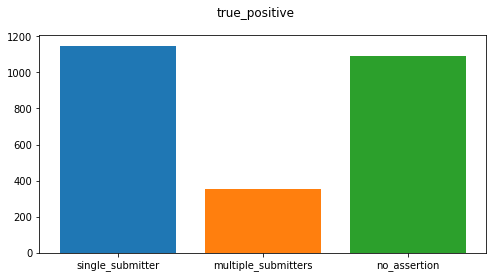

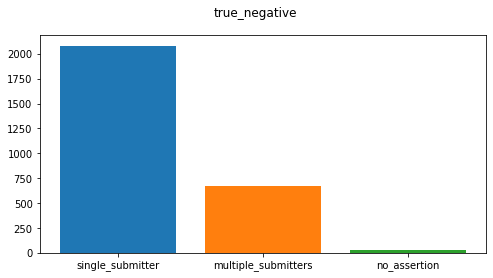

In [21]:
tp = draw_clinvar_find('true_positive', omit, clinvar, basic_check,omit_gb[1], omit_gb[0])
tn = draw_clinvar_find('true_negative', omit, clinvar, basic_check,omit_gb[1], omit_gb[0])

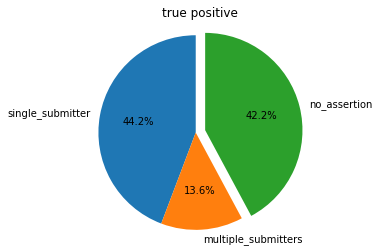

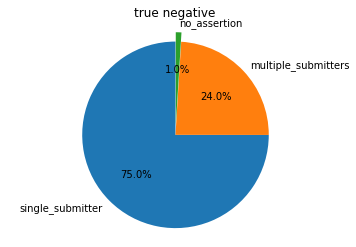

In [22]:
pie(tp, 'true positive')
pie(tn, 'true negative')

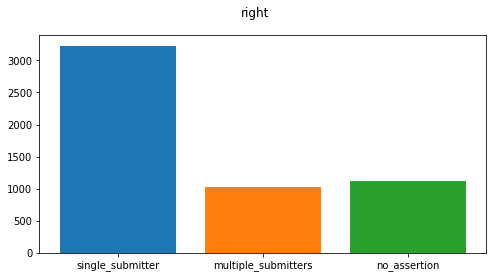

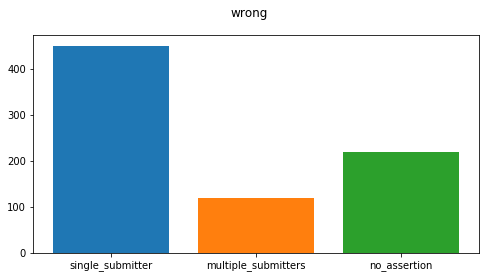

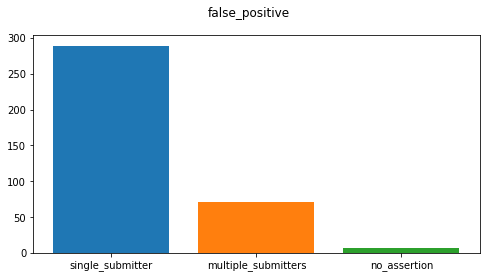

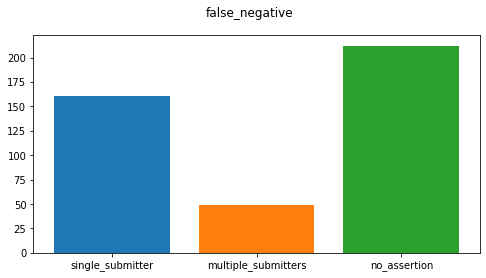

In [56]:
right = draw_clinvar_find('right', omit, clinvar, basic_check,omit_gb[1], omit_gb[0])
wrong = draw_clinvar_find('wrong', omit, clinvar, basic_check,omit_gb[1], omit_gb[0])
fp = draw_clinvar_find('false_positive', omit, clinvar, basic_check,omit_gb[1], omit_gb[0])
fn = draw_clinvar_find('false_negative', omit, clinvar, basic_check,omit_gb[1], omit_gb[0])


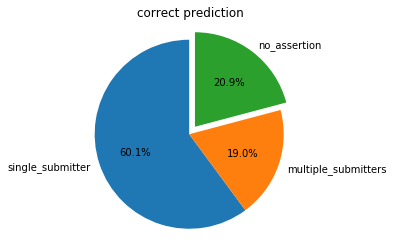

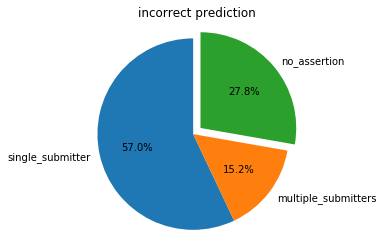

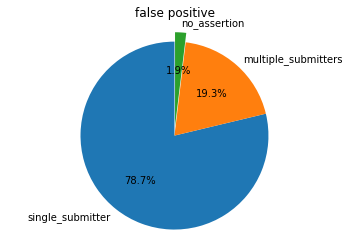

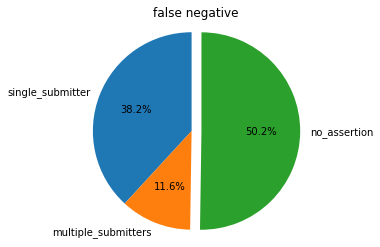

In [57]:
pie(right, 'correct prediction')
pie(wrong, 'incorrect prediction')
pie(fp, 'false positive')
pie(fn, 'false negative')

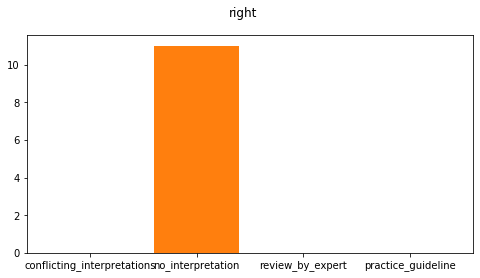

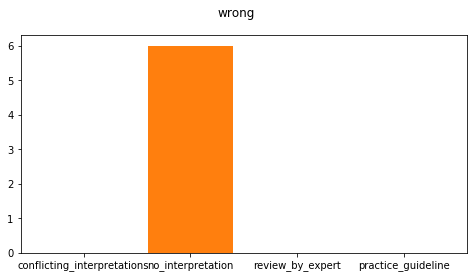

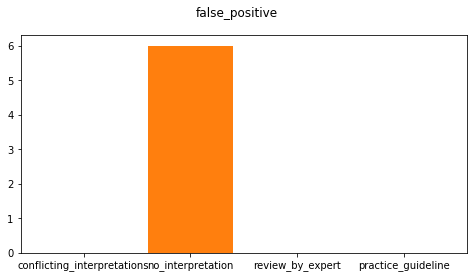

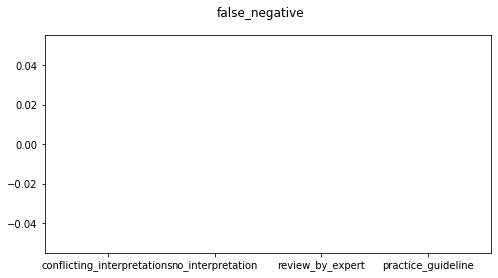

[0, 0, 0, 0]

In [23]:
draw_clinvar_find('right', omit, clinvar, further_check, omit_gb[1], omit_gb[0])
draw_clinvar_find('wrong', omit, clinvar, further_check, omit_gb[1], omit_gb[0])
draw_clinvar_find('false_positive', omit, clinvar, further_check, omit_gb[1], omit_gb[0])
draw_clinvar_find('false_negative', omit, clinvar, further_check, omit_gb[1], omit_gb[0])


In [43]:
def chisquare(array1, array2):
    chisq, pvalue, table = proportion.proportions_chisquare(array1, array2)
    print('Results are ','chisq =%.3f, pvalue = %.5f'%(chisq, pvalue))

In [44]:
from scipy.stats import chi2_contingency
def chi2(arr1, arr2):
    pvalue = chi2_contingency([arr1, arr2])[1]
    print('p value =', pvalue , '\n')

    

In [45]:
#comparing chi square result

print('comparison between having submitters and not having submitter:')
chi2([right[0] + right[1], fp[0] + fp[1], fn[0] + fn[1]], [right[2], fp[2], fn[2]])

print('comparison between having one and not having submitter:')
chi2([right[0] , fp[0] , fn[0]], [right[2], fp[2], fn[2]])

print('comparison between single submitter and multiple submitters:')
chi2([right[0], fp[0], fn[0]], [right[1], fp[1], fn[1]])




comparison between having submitters and not having submitter:
p value = 2.1889442855481075e-63 

comparison between having one and not having submitter:
p value = 3.4297244505853295e-58 

comparison between single submitter and multiple submitters:
p value = 0.1825141855014456 



In [46]:
#remove no_assertion_criteria_provided data
no_assertion = clinvar[clinvar['info'].str.contains('no_assertion')]['location']
omit_new = omit[~omit['location'].isin(no_assertion)]

no_interpretation = clinvar[clinvar['info'].str.contains('no_interpretation')]['location']
omit_new = omit_new[~omit_new['location'].isin(no_interpretation)]

In [47]:
omit_new.to_csv('omit_with_criteria.tsv', sep = '\t',index = False)

In [107]:
clinvar_find(omit_new, clinvar, findpattern ='no_assertion')[1]

0

In [147]:
omit_new.shape

(48914, 33)

In [48]:
X_train_new, X_valid_new, X_test_new, y_train_new, y_valid_new, y_test_new = split(omit_new, x_column, y_column)
tuning(X_valid_new, y_valid_new, 'gradient boosting', tuned_parameters)

# Tuning hyper-parameters for recall



/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameters set found on development set:
{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}
With score : 0.873

Grid scores on development set:

0.865 (+/-0.007) for {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
0.867 (+/-0.005) for {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 150}
0.869 (+/-0.006) for {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
0.867 (+/-0.003) for {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
0.871 (+/-0.004) for {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 150}
0.873 (+/-0.001) for {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}
0.865 (+/-0.006) for {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 100}
0.866 (+/-0.010) for {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 150}
0.868 (+/-0.006) for {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 200}
0.867 (+/-0.007) for {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
0.866 (+/-0.004) for 

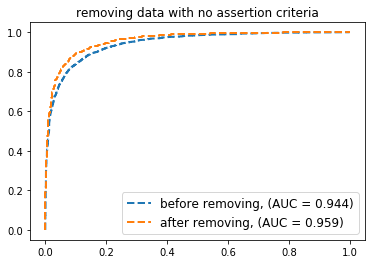

In [153]:
omit_gb_new = fitting_gb(X_train_new, y_train_new, X_test_new, y_test_new, 0.1, 5, 200)
drawROC(omit_gb[0], omit_gb[1], label = 'before removing', lw = 2)
drawROC(omit_gb_new[0], omit_gb_new[1], label = 'after removing', lw = 2, lastone = True, title = 'removing data with no assertion criteria')

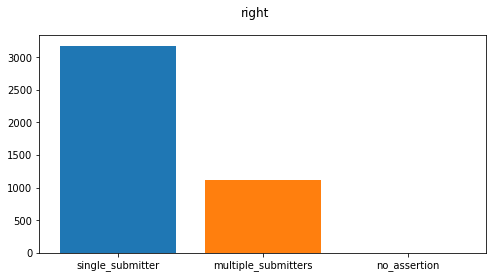

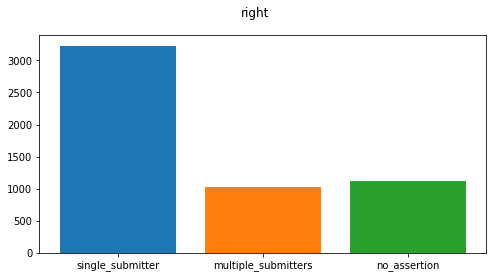

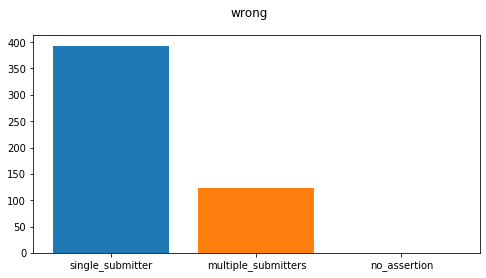

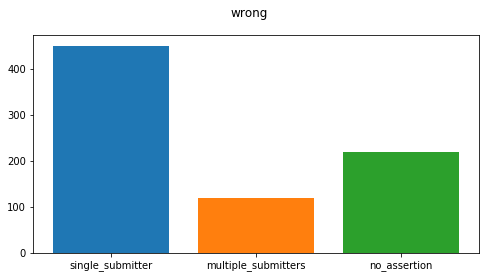

[450, 120, 219]

In [135]:
# double check that there is no data that have no assertion criteria in omit_new
draw_clinvar_find('right', omit_new, clinvar, basic_check,omit_gb_new[1], omit_gb_new[0])
draw_clinvar_find('right', omit, clinvar, basic_check,omit_gb[1], omit_gb[0])

draw_clinvar_find('wrong', omit_new, clinvar, basic_check,omit_gb_new[1], omit_gb_new[0])
draw_clinvar_find('wrong', omit, clinvar, basic_check,omit_gb[1], omit_gb[0])

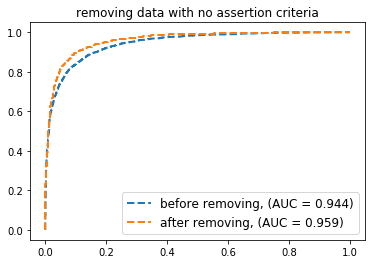

In [32]:
omit_gb_new = fitting_gb(X_train_new, y_train_new, X_test_new, y_test_new, 0.05, 8, 200)
drawROC(omit_gb[0], omit_gb[1], label = 'before removing', lw = 2)
drawROC(omit_gb_new[0], omit_gb_new[1], label = 'after removing', lw = 2, lastone = True, title = 'removing data with no assertion criteria')

In [23]:
# protein structure prediction

def find_any_column(df, predict , correct , type_of_result, column):
    
    if(type_of_result == 'false_positive'):
        pos = 4
    elif(type_of_result == 'false_negative'):
        pos = 5
    elif(type_of_result == 'true_positive'):
        pos = 1
    elif(type_of_result == 'true_negative'):
        pos = 2
    loc = prediction_location(predict, correct)[pos][0]
    return(df.iloc[np.r_[loc],column])
    

In [24]:
tp = find_any_column(X_test, omit_gb[1],  omit_gb[0], 'true_positive',14) 
tn = find_any_column(X_test, omit_gb[1],  omit_gb[0], 'true_negative',14) 
fp = find_any_column(X_test, omit_gb[1],  omit_gb[0], 'false_positive',14) 
fn = find_any_column(X_test, omit_gb[1],  omit_gb[0], 'false_negative',14) 

correct = tp.append(tn)
incorrect = fp.append(fn)

In [130]:
df1 = pd.DataFrame(
    { 'values': tp,
     'types': 'tp'    
    }
    )

df2 = pd.DataFrame(
    { 'values': tn,
     'types': 'tn'    
    }
    )

df3 = pd.DataFrame(
    { 'values': fp,
     'types': 'fp'    
    }
    )

df4 = pd.DataFrame(
    { 'values': fn,
     'types': 'fn'    
    }
    )

df_violin = pd.concat([df1, df2, df3, df4])


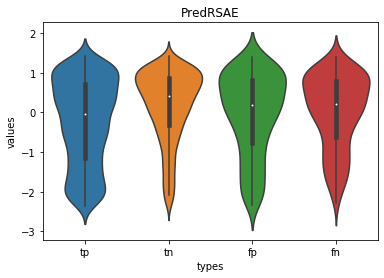

In [135]:
ax = sns.violinplot(x = 'types', y = 'values', data = df_violin, scale = "width")
ax.set_title('%s'%('PredRSAE'))
plt.savefig('figure/4_violinplot_RSAE.eps')

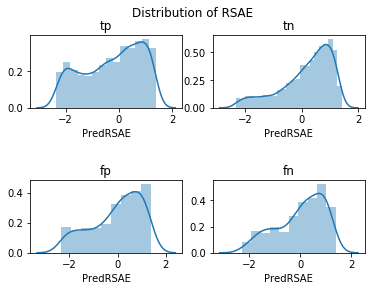

In [25]:
import seaborn as sns

fig, axes = plt.subplots(nrows=2, ncols = 2)
fig.subplots_adjust(hspace=1)
fig.suptitle('Distribution of %s'%('RSAE'))

for ax, feature, name in zip(axes.flatten(), [tp, tn, fp, fn],['tp', 'tn', 'fp','fn']): 
    sns.distplot(feature, ax=ax)
    
    ax.set(title=name)
plt.show()

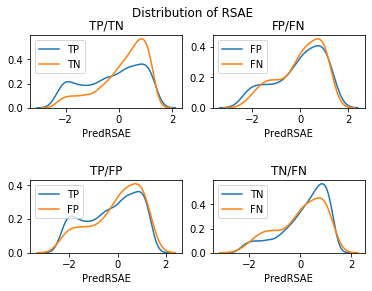

In [28]:

fig, axes = plt.subplots(nrows=2, ncols = 2)
fig.subplots_adjust(hspace=1)
fig.suptitle('Distribution of %s'%('RSAE'))


for ax, feature1, feature2, name in zip(axes.flatten(), [tp, fp, tp, tn],[tn, fn, fp, fn],['TP/TN', 'FP/FN', 'TP/FP','TN/FN']): 
    sns.distplot(feature1, ax = ax, hist = False, label = name[:2])
    sns.distplot(feature2, ax = ax, hist = False, label = name[3:])
    
    
    ax.set(title=name)
plt.show()

In [118]:
# use both statmodels and scipy to double check
# there is significant difference between tp and tn 

## this is an parametric test(required them to follow normal distribution)
## we should use non parametric test if not assumed the sampled distribution is normal distribution 
import statsmodels
print(statsmodels.stats.weightstats.ttest_ind(tp, tn))

from scipy.stats import ttest_ind
print(ttest_ind(tp, tn))

(-14.90625022641073, 2.772770261458215e-49, 5454.0)
Ttest_indResult(statistic=-14.906250226410732, pvalue=2.7727702614580966e-49)


In [136]:
from scipy import stats
stats.ks_2samp(tp, tn)

Ks_2sampResult(statistic=0.18682702051020333, pvalue=0.9971045388729833)

In [229]:
# there is no significant difference between all the correctly predicted and incorrectly predicted sample (in total)
print("p values is %s"%(ttest_ind(correct, incorrect)[1]))

# but there is significantly difference between the correctly predicted and incorrectly predicted sample
# in both benign and pathogenic groups
print("p values is %s"%(ttest_ind(tp, fp)[1]))
print("p values is %s"%(ttest_ind(tn, fn)[1]))


p values is 0.5831940085084271
p values is 0.0009390027524144425
p values is 0.0014402981085781634


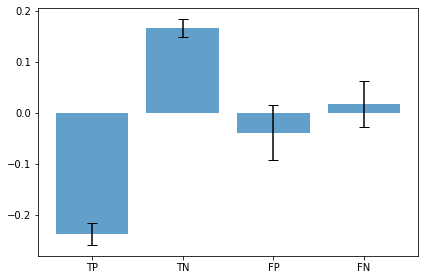

In [26]:
names = ['TP', 'TN', 'FP', 'FN']
means = [tp.mean(), tn.mean(), fp.mean(), fn.mean()]
stds = [tp.sem(), tn.sem(), fp.sem(), fn.sem()]
fig, ax = plt.subplots()
ax.bar(np.arange(4),means, yerr = stds, align = 'center', alpha = 0.7, ecolor = 'black', capsize= 5)
ax.set_xticks(np.arange(4))
ax.set_xticklabels(names)
plt.tight_layout()

In [243]:
tp.sem

0.02118413382504548

In [164]:
def overall(df, predict , correct , col, col_name):
    tp = find_any_column(df, predict,  correct, 'true_positive',col) 
    tn = find_any_column(df, predict,  correct, 'true_negative',col) 
    fp = find_any_column(df, predict,  correct, 'false_positive',col) 
    fn = find_any_column(df, predict,  correct, 'false_negative',col) 

    correct = tp.append(tn)
    incorrect = fp.append(fn)
    
    
    # draw violin plot
    df1 = pd.DataFrame(
    { 'values': tp,
     'types': 'tp'    
    })

    df2 = pd.DataFrame(
    { 'values': tn,
     'types': 'tn'    
    })

    df3 = pd.DataFrame(
    { 'values': fp,
     'types': 'fp'    
    })

    df4 = pd.DataFrame(
    { 'values': fn,
     'types': 'fn'    
    })

    df_violin = pd.concat([df1, df2, df3, df4])
    ax = sns.violinplot(x = 'types', y = 'values', data = df_violin, x_axis = False)
    ax.set_title('%s'%(col_name))
    
    # calculate p value
    #print("p values between correct and incorrect groups is %s"%(ttest_ind(correct, incorrect)[1]))
    print("p values between correct and incorrect groups is %s \n"%(stats.ks_2samp(correct, incorrect)[1]))

    #print("p values between tp and fp is %s"%(ttest_ind(tp, fp)[1]))
    print("p values between tp and fp is %s \n"%(stats.ks_2samp(tp, fp)[1]))

    #print("p values between tn and fn is %s"%(ttest_ind(tn, fn)[1]))
    print("p values between tn and fn is %s \n"%(stats.ks_2samp(tn, fn)[1]))
 
    print("p values between tp and tn is %s \n"%(stats.ks_2samp(tn, tp)[1]))

    print("p values between fp and fn is %s \n"%(stats.ks_2samp(fp, fn)[1]))
    
    print("p values between tp and fn is %s \n"%(stats.ks_2samp(tp, fn)[1]))
    
    print("p values between tn and fp is %s \n"%(stats.ks_2samp(tn, fp)[1]))

    
    
    # draw dist plot
    
#     fig, axes = plt.subplots(nrows=2, ncols = 2, figsize=(10,6))
    
#     fig.subplots_adjust(hspace=0.5)
#     fig.suptitle('Distribution of %s'%(col_name))

#     for ax, feature1, feature2, name in zip(axes.flatten(), [tp, fp, tp, tn],[tn, fn, fp, fn],['TP;TN', 'FP;FN', 'TP;FP','TN;FN']): 
#         sns.distplot(feature1, ax = ax, hist = False, label = name[:2])
#         sns.distplot(feature2, ax = ax, hist = False, label = name[3:])
#         ax.set(title=name)

#     plt.show()
    
    
    
        
    # draw mean comparison
#     names = ['TP', 'TN', 'FP', 'FN']
#     means = [tp.mean(), tn.mean(), fp.mean(), fn.mean()]
#     stds = [tp.sem(), tn.sem(), fp.sem(), fn.sem()]
#     fig, ax = plt.subplots()
#     ax.bar(np.arange(4),means, yerr = stds, align = 'center', alpha = 0.7, ecolor = 'black', capsize= 5)
#     ax.set_xticks(np.arange(4))
#     ax.set_xticklabels(names)
#     plt.tight_layout()
#     plt.title('mean comparison')

In [145]:
X_test.columns

Index(['SIFT_pred', 'LRT_pred', 'MA_pred', 'PROVEN_pred', 'SLR_score',
       'SIFT_score', 'LRT_omega', 'MA_score', 'PROVEN_score', 'Grantham',
       'HMMEntropy', 'HMMRelEntropy', 'PredRSAB', 'PredRSAI', 'PredRSAE',
       'PredBFactorF', 'PredBFactorM', 'PredBFactorS', 'PredStabilityH',
       'PredStabilityM', 'PredStabilityL', 'PredSSE', 'PredSSH', 'PredSSC',
       'dscore', 'phyloP_pri', 'phyloP_mam', 'phyloP_ver', 'RNA_seq',
       'UNEECON'],
      dtype='object')

p values between correct and incorrect groups is 0.6691297957469389 

p values between tp and fp is 0.0005934769062153622 

p values between tn and fn is 0.005391159065641693 

p values between tp and tn is 0.9971045388729833 

p values between fp and fn is 0.5512867681710389 

p values between tp and fn is 1.2954575511869848e-05 

p values between tn and fp is 0.002919667502746859 



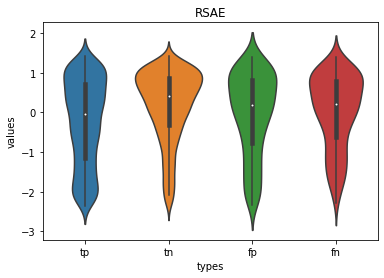

In [165]:
overall(X_test, omit_gb[1],  omit_gb[0], 14, 'RSAE')

p values between correct and incorrect groups is 0.505568367699267 

p values between tp and fp is 0.07899558485722524 

p values between tn and fn is 0.0008033807357502587 

p values between tp and tn is 0.9971045388729833 

p values between fp and fn is 0.6374595409843395 

p values between tp and fn is 0.007541247884305324 

p values between tn and fp is 0.0033584940638039518 



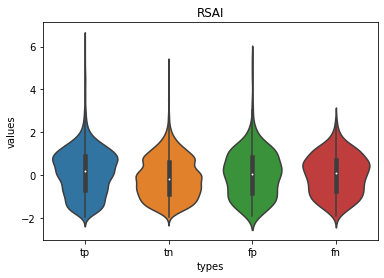

In [166]:
#predRSAI
overall(X_test, omit_gb[1],  omit_gb[0], 13,'RSAI')

In [168]:
X_test.columns

Index(['SIFT_pred', 'LRT_pred', 'MA_pred', 'PROVEN_pred', 'SLR_score',
       'SIFT_score', 'LRT_omega', 'MA_score', 'PROVEN_score', 'Grantham',
       'HMMEntropy', 'HMMRelEntropy', 'PredRSAB', 'PredRSAI', 'PredRSAE',
       'PredBFactorF', 'PredBFactorM', 'PredBFactorS', 'PredStabilityH',
       'PredStabilityM', 'PredStabilityL', 'PredSSE', 'PredSSH', 'PredSSC',
       'dscore', 'phyloP_pri', 'phyloP_mam', 'phyloP_ver', 'RNA_seq',
       'UNEECON'],
      dtype='object')

p values between correct and incorrect groups is 0.1550719917783812 

p values between tp and fp is 2.833951432412718e-07 

p values between tn and fn is 0.00042121233280623116 

p values between tp and tn is 0.9971045388729833 

p values between fp and fn is 0.00030465532747969704 

p values between tp and fn is 2.9976021664879227e-15 

p values between tn and fp is 8.881784197001252e-15 



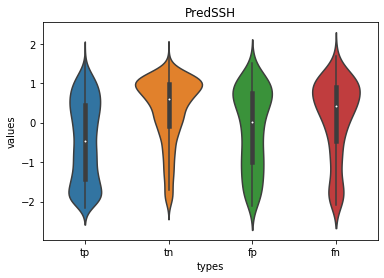

In [171]:
overall(X_test, omit_gb[1],  omit_gb[0], 22,'PredSSH')

p values between correct and incorrect groups is 1.1863358227286131e-14 

p values between tp and fp is 1.2212453270876722e-15 

p values between tn and fn is 2.886579864025407e-15 

p values between tp and tn is 0.9971045388729833 

p values between fp and fn is 3.090181412588528e-40 

p values between tp and fn is 4.565894951961885e-143 

p values between tn and fp is 6.661338147750939e-16 



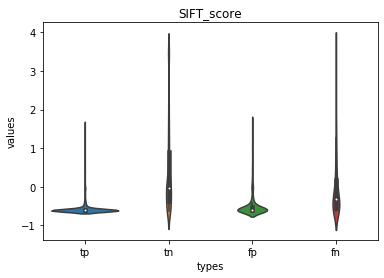

In [169]:
overall(X_test, omit_gb[1],  omit_gb[0], 5,'SIFT_score')

p values between correct and incorrect groups is 1.2528250307905468e-20 

p values between tp and fp is 1.2212453270876722e-15 

p values between tn and fn is 2.886579864025407e-15 

p values between tp and tn is 0.9971045388729833 

p values between fp and fn is 1.2391309579337417e-43 

p values between tp and fn is 7.947058941448659e-157 

p values between tn and fp is 6.661338147750939e-16 



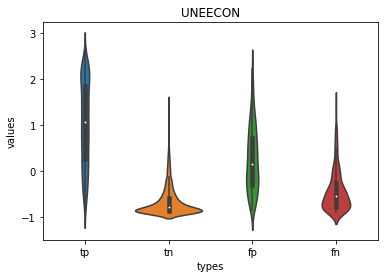

In [167]:
overall(X_test, omit_gb[1],  omit_gb[0], 29,'UNEECON')

In [385]:
prediction_location(omit_gb[1], omit_gb[1])[1][0]
X_test.iloc[np.r_[tp_loc],5:13]

X_test.iloc[np.r_[tp_loc],10:16]



,HMMEntropy,HMMRelEntropy,PredRSAB,PredRSAI,PredRSAE,PredBFactorF
43143,0.788529,0.298194,-0.775546,-1.690883,1.293349,-0.157798
19243,-0.650601,-0.617531,-0.674150,-0.659716,0.783473,-1.217218
14143,2.429252,3.020835,0.770758,0.995578,-0.997289,-0.687507
77278,0.067200,-0.013331,1.906405,0.434769,-1.613708,3.550171
11412,2.153968,2.515976,2.671953,0.217681,-2.096950,1.961042
...,...,...,...,...,...,...
2185,-0.576357,-0.555176,-0.755267,-1.301934,1.114511,-0.157798
16974,-0.735891,-0.594525,-0.572752,-0.442628,0.612246,0.901621
74235,-0.067198,0.198683,1.303093,1.022715,-1.408236,-0.687507
9189,-0.555560,-0.481002,0.106607,0.326225,-0.217256,-0.687507


In [254]:
len(fn)  #434
len(fp)  #374

374

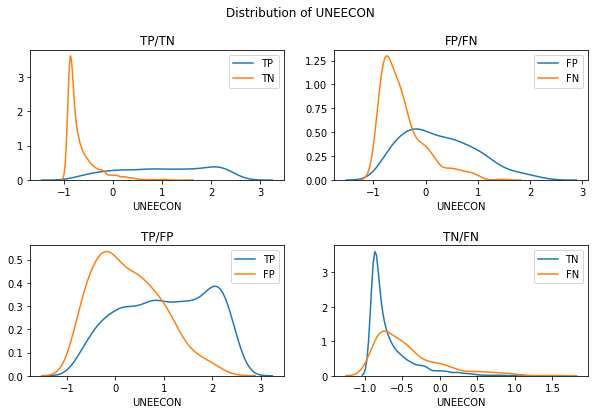

p values between correct and incorrect groups is 3.2781824369908932e-12
p values between tp and fp is 3.0361404227747827e-53
p values between tn and fn is 8.217147443312917e-38


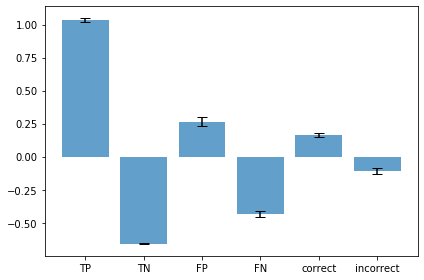

In [390]:
overall(X_test, omit_gb[1],  omit_gb[0], 29, 'UNEECON')

In [263]:
X_test.loc[:,'SIFT_score'].corr( X_test.loc[:, 'PredRSAE'], method = 'spearman')

0.12254576845371014

In [264]:
X_test.columns

Index(['SIFT_pred', 'LRT_pred', 'MA_pred', 'PROVEN_pred', 'SLR_score',
       'SIFT_score', 'LRT_omega', 'MA_score', 'PROVEN_score', 'Grantham',
       'HMMEntropy', 'HMMRelEntropy', 'PredRSAB', 'PredRSAI', 'PredRSAE',
       'PredBFactorF', 'PredBFactorM', 'PredBFactorS', 'PredStabilityH',
       'PredStabilityM', 'PredStabilityL', 'PredSSE', 'PredSSH', 'PredSSC',
       'dscore', 'phyloP_pri', 'phyloP_mam', 'phyloP_ver', 'RNA_seq',
       'UNEECON'],
      dtype='object')

In [254]:
a is b # 

False

In [256]:
c = a

In [257]:
c is a

True

In [259]:
c[:] =5

In [260]:
a

array([[5, 5],
       [5, 5]])